# PAQUETES

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx #agregar mosaicos a los mapas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib # para exportar el modelo

# DATOS DE PRESENCIA Y AUSENCIA DE LA ESPECIE

In [2]:
#Cargar presencias de la especie
data = gpd.read_file(r'Data/Species/sp6_only_1_0.shp')
data

,ET_ID,COUNTRY,x,y,sp6_data,geometry
0,249,Spain,-2,35,0,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839..."
1,588,Spain,-6,36,0,"POLYGON ((-5.66819 35.70229, -6.2074 35.6087, ..."
2,639,Greece,22,36,0,"POLYGON ((22.49703 36.18599, 21.95053 36.25796..."
3,708,Spain,-3,37,0,"POLYGON ((-3.03773 36.57051, -3.5857 36.4921, ..."
4,754,Greece,22,37,0,"POLYGON ((22.57664 36.63389, 22.02682 36.70639..."
...,...,...,...,...,...,...
979,9258,Norway,31,70,0,"POLYGON ((31.51354 69.65136, 30.2985 69.78745,..."
980,9368,Norway,25,71,0,"POLYGON ((25.63446 70.69412, 24.32877 70.79281..."
981,9370,Norway,28,71,0,"POLYGON ((28.20775 70.47181, 26.92771 70.58708..."
982,9371,Norway,29,71,0,"POLYGON ((29.47384 70.34844, 28.20775 70.47181..."


In [3]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ET_ID     984 non-null    int64   
 1   COUNTRY   984 non-null    object  
 2   x         984 non-null    int64   
 3   y         984 non-null    int64   
 4   sp6_data  984 non-null    int64   
 5   geometry  984 non-null    geometry
dtypes: geometry(1), int64(4), object(1)
memory usage: 46.3+ KB


In [4]:
data['sp6_data'].unique()

array([0, 1])

Observamos que hay 1170 cuadriculas con presencia y ausencia de la especie.

In [5]:
# Renombrar columnas
data.rename(columns = {'x': 'X', 'y':'Y'}, inplace=True)
data.head(3)

,ET_ID,COUNTRY,X,Y,sp6_data,geometry
0,249,Spain,-2,35,0,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839..."
1,588,Spain,-6,36,0,"POLYGON ((-5.66819 35.70229, -6.2074 35.6087, ..."
2,639,Greece,22,36,0,"POLYGON ((22.49703 36.18599, 21.95053 36.25796..."


Se observa que en total hay 1170 cuadriculas con presencia/ausencia de la especie

# DATOS DE PRESENCIA/AUSNCIA EN TODA EL AREA DE ESTUIDO

In [6]:
#Cargar el grid
grid = gpd.read_file(r'Data/Species/sp6_presence_absence.shp')
grid

,ET_ID,COUNTRY,x,y,sp6_data,geometry
0,249,Spain,-2,35,0.0,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839..."
1,280,Malta,14,36,NaN,"POLYGON ((14.68659 35.53849, 14.14122 35.56449..."
2,363,Spain,-3,35,NaN,"POLYGON ((-2.79499 35.22702, -3.33331 35.15029..."
3,412,Greece,24,35,NaN,"POLYGON ((23.95653 35.05738, 23.41935 35.13773..."
4,413,Greece,24,35,NaN,"POLYGON ((24.49271 34.97391, 23.95653 35.05738..."
...,...,...,...,...,...,...
3101,9369,Norway,26,71,NaN,"POLYGON ((26.92771 70.58708, 25.63446 70.69412..."
3102,9370,Norway,28,71,0.0,"POLYGON ((28.20775 70.47181, 26.92771 70.58708..."
3103,9371,Norway,29,71,0.0,"POLYGON ((29.47384 70.34844, 28.20775 70.47181..."
3104,9372,Norway,30,70,NaN,"POLYGON ((30.72534 70.21713, 29.47384 70.34844..."


En la malla de 50x50 Km se observa que hay un total de 3106 cuadriculas, por lo que deberia haber 1936 cuadricuals con valores nulos para el capo 'sp6_data'.

In [7]:
print('Valores faltantes por columna:')
grid.isnull().sum()

Valores faltantes por columna:


ET_ID          0
COUNTRY        0
x              0
y              0
sp6_data    2122
geometry       0
dtype: int64

Se observa que el número de valores nulos es correcto.

# DATOS DE LAS VARIABLES INDEPENDIENTES

In [8]:
#Cargar variables_seleccionadas_SDM
variables_seleccionadas_SDM = pd.read_csv('Data/Variables/Current/variables_seleccionadas_SDM.csv')
variables_seleccionadas_SDM

,ET_ID,X,Y,ET_ID.1,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea,X.1,Y.1
0,249,-2,35,249,35.2700,0.0000,0.0000,37.6820,18.2550,8.4956,0.3680,462.7157,29.4562,13.8649,345.2101,57.2502,-2,35
1,280,14,36,280,90.1848,0.0000,0.0000,5.5578,19.1658,1.5286,0.1101,436.0108,26.6743,16.1710,510.0062,83.7500,14,36
2,363,-3,35,363,83.4716,0.0000,0.0000,10.1952,18.4622,3.7568,0.2389,374.3991,26.1882,14.9681,379.8207,62.7896,-3,35
3,412,24,35,412,45.9390,2.0083,0.0374,16.6332,17.7280,4.3377,0.2251,507.0172,27.5252,13.1808,802.8021,93.5241,24,35
4,413,24,35,413,49.8403,0.1527,0.0000,20.5800,17.6329,3.9212,0.2078,509.2899,26.9524,13.0027,734.0307,90.5660,24,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,9369,26,71,9369,72.8802,0.6315,0.8244,19.0309,1.7978,3.6218,0.1800,568.0532,12.3476,1.9057,883.6893,23.0387,26,71
3102,9370,28,71,9370,31.7366,3.1084,2.9499,44.8952,0.0086,4.6590,0.1871,700.4837,12.8276,4.7798,1006.3917,21.2239,28,71
3103,9371,29,71,9371,22.5336,1.4641,2.1897,45.5301,-0.3992,4.6670,0.1878,700.7738,12.4518,6.0630,961.8566,21.9798,29,71
3104,9372,30,70,9372,36.3293,0.5840,0.5660,38.9411,0.6273,3.8214,0.1830,591.6142,11.3338,6.2982,867.1089,21.2617,30,70


In [9]:
print('Valores faltantes por columna:')
variables_seleccionadas_SDM.isnull().sum()

Valores faltantes por columna:


ET_ID         0
X             0
Y             0
ET_ID.1       0
%_H_1         0
%_H_2         0
%_H_3         0
%_H_4         0
Bio_01_mea    0
Bio_02_mea    0
Bio_03_mea    0
Bio_04_mea    0
Bio_05_mea    0
Bio_08_mea    0
Bio_12_mea    0
Bio_15_mea    0
X.1           0
Y.1           0
dtype: int64

In [10]:
columns_select = ('ET_ID',  '%_H_1', '%_H_2', '%_H_3', '%_H_4',
       'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea',
       'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea')

# Selecciona solo las columnas especificadas en la lista columns_select
variables_seleccionadas_SDM = variables_seleccionadas_SDM[list(columns_select)]
variables_seleccionadas_SDM.columns

Index(['ET_ID', '%_H_1', '%_H_2', '%_H_3', '%_H_4', 'Bio_01_mea', 'Bio_02_mea',
       'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea',
       'Bio_15_mea'],
      dtype='object')

Observamos que no hay valores nulos en niguna de las variables independientes seleccionadas. Se han eliminado algunas columnas duplicadas o innecesarias.

# DATAFRAME COMPLETO

In [11]:
all_data = grid.merge(variables_seleccionadas_SDM, on= 'ET_ID')
all_data

,ET_ID,COUNTRY,x,y,sp6_data,geometry,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,249,Spain,-2,35,0.0,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839...",35.2700,0.0000,0.0000,37.6820,18.2550,8.4956,0.3680,462.7157,29.4562,13.8649,345.2101,57.2502
1,280,Malta,14,36,NaN,"POLYGON ((14.68659 35.53849, 14.14122 35.56449...",90.1848,0.0000,0.0000,5.5578,19.1658,1.5286,0.1101,436.0108,26.6743,16.1710,510.0062,83.7500
2,363,Spain,-3,35,NaN,"POLYGON ((-2.79499 35.22702, -3.33331 35.15029...",83.4716,0.0000,0.0000,10.1952,18.4622,3.7568,0.2389,374.3991,26.1882,14.9681,379.8207,62.7896
3,412,Greece,24,35,NaN,"POLYGON ((23.95653 35.05738, 23.41935 35.13773...",45.9390,2.0083,0.0374,16.6332,17.7280,4.3377,0.2251,507.0172,27.5252,13.1808,802.8021,93.5241
4,413,Greece,24,35,NaN,"POLYGON ((24.49271 34.97391, 23.95653 35.05738...",49.8403,0.1527,0.0000,20.5800,17.6329,3.9212,0.2078,509.2899,26.9524,13.0027,734.0307,90.5660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,9369,Norway,26,71,NaN,"POLYGON ((26.92771 70.58708, 25.63446 70.69412...",72.8802,0.6315,0.8244,19.0309,1.7978,3.6218,0.1800,568.0532,12.3476,1.9057,883.6893,23.0387
3102,9370,Norway,28,71,0.0,"POLYGON ((28.20775 70.47181, 26.92771 70.58708...",31.7366,3.1084,2.9499,44.8952,0.0086,4.6590,0.1871,700.4837,12.8276,4.7798,1006.3917,21.2239
3103,9371,Norway,29,71,0.0,"POLYGON ((29.47384 70.34844, 28.20775 70.47181...",22.5336,1.4641,2.1897,45.5301,-0.3992,4.6670,0.1878,700.7738,12.4518,6.0630,961.8566,21.9798
3104,9372,Norway,30,70,NaN,"POLYGON ((30.72534 70.21713, 29.47384 70.34844...",36.3293,0.5840,0.5660,38.9411,0.6273,3.8214,0.1830,591.6142,11.3338,6.2982,867.1089,21.2617


In [12]:
all_data.columns

Index(['ET_ID', 'COUNTRY', 'x', 'y', 'sp6_data', 'geometry', '%_H_1', '%_H_2',
       '%_H_3', '%_H_4', 'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea',
       'Bio_04_mea', 'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea'],
      dtype='object')

In [13]:
print('Valores faltantes por columna:')
all_data.isnull().sum()

Valores faltantes por columna:


ET_ID            0
COUNTRY          0
x                0
y                0
sp6_data      2122
geometry         0
%_H_1            0
%_H_2            0
%_H_3            0
%_H_4            0
Bio_01_mea       0
Bio_02_mea       0
Bio_03_mea       0
Bio_04_mea       0
Bio_05_mea       0
Bio_08_mea       0
Bio_12_mea       0
Bio_15_mea       0
dtype: int64

In [14]:
all_data['sp6_data'].unique()

array([ 0., nan,  1.])

In [15]:
# Convertir a Int64 (entero nullable)
all_data['sp6_data'] = all_data['sp6_data'].astype('Int64')
all_data

# Mostrar el tipo de dato de la columna
print("\nTipo de dato de la columna 'sp6_data':")
print(all_data['sp6_data'].dtype)


Tipo de dato de la columna 'sp6_data':
Int64


In [16]:
all_data['sp6_data'].unique()

<IntegerArray>
[0, <NA>, 1]
Length: 3, dtype: Int64

In [17]:
all_data['sp6_data'].value_counts(dropna=False)

sp6_data
<NA>    2122
0        692
1        292
Name: count, dtype: Int64

Se observa que todos los datos son correctos segun los números de cuadriculas para cada valor:
- Presencia de la especie (1): 292 cuadrículas.
- Ausencia de la especies (0): 692 cuadrículas.
- Valores nulos (NA): 2122 cuadrículas

In [18]:
# Filtrar las filas donde el campo 'sp6_data' es mayor o igual a 0
only_data_sp6 = all_data[all_data['sp6_data'].fillna(-1) >= 0]
only_data_sp6

,ET_ID,COUNTRY,x,y,sp6_data,geometry,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,249,Spain,-2,35,0,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839...",35.2700,0.0000,0.0000,37.6820,18.2550,8.4956,0.3680,462.7157,29.4562,13.8649,345.2101,57.2502
12,588,Spain,-6,36,0,"POLYGON ((-5.66819 35.70229, -6.2074 35.6087, ...",85.1204,0.0000,0.0000,8.7177,17.9922,4.0981,0.2769,340.2360,25.7906,14.9541,695.6477,76.4234
18,639,Greece,22,36,0,"POLYGON ((22.49703 36.18599, 21.95053 36.25796...",90.3469,0.1075,0.0123,1.7041,18.3815,1.8009,0.1176,468.7720,26.3705,14.7347,779.1252,97.7177
26,708,Spain,-3,37,0,"POLYGON ((-3.03773 36.57051, -3.5857 36.4921, ...",44.7791,4.0555,0.1713,18.0419,16.6086,4.5969,0.2359,463.0497,26.2301,12.1890,476.7289,65.7902
37,754,Greece,22,37,0,"POLYGON ((22.57664 36.63389, 22.02682 36.70639...",28.4112,6.2892,3.3552,20.4948,15.9845,6.2999,0.2653,577.6150,28.1616,10.7472,938.9677,85.5936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,9258,Norway,31,70,0,"POLYGON ((31.51354 69.65136, 30.2985 69.78745,...",90.7157,0.7716,0.0659,7.8493,1.7734,2.9298,0.1580,545.8960,11.2307,6.0093,672.2475,22.8557
3100,9368,Norway,25,71,0,"POLYGON ((25.63446 70.69412, 24.32877 70.79281...",50.0016,1.7230,0.1630,43.1661,2.0512,3.2529,0.1788,514.7891,11.5722,0.2492,1130.3531,23.9621
3102,9370,Norway,28,71,0,"POLYGON ((28.20775 70.47181, 26.92771 70.58708...",31.7366,3.1084,2.9499,44.8952,0.0086,4.6590,0.1871,700.4837,12.8276,4.7798,1006.3917,21.2239
3103,9371,Norway,29,71,0,"POLYGON ((29.47384 70.34844, 28.20775 70.47181...",22.5336,1.4641,2.1897,45.5301,-0.3992,4.6670,0.1878,700.7738,12.4518,6.0630,961.8566,21.9798


In [19]:
only_data_sp6['sp6_data'].value_counts(dropna=False)

sp6_data
0    692
1    292
Name: count, dtype: Int64

In [20]:
# También puedes especificar el separador decimal al guardar en un shapefile
#all_data.to_file('DATA_SDM/ALL_DATA_SP6_SDM.shp')
#only_data_sp6.to_file('DATA_SDM/DATA_SP6_SDM.shp')


# MODELO DE DISTRIBUCIÓN DE ESPECIES

Inicialmente el modelo se realizará y entrenará con el conjunto de datos "only_data_sp6.shp" ya que solo contiene las cuadricualas donde hay presencia o ausencia de la especies. 

Posteriormente se utilizará el modelo para predecir la probabilidad de presencia de la especie en todas las cuadriculas del area de estudio (tengan o no datos sobre la presencia o ausencia de la especie). De igual modo, se utilizará el modelo para predecir la probabilidad de presencia de la especie en los dos escenarios a futuro de cara a 2050.

In [21]:
only_data_sp6.head()

,ET_ID,COUNTRY,x,y,sp6_data,geometry,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,249,Spain,-2,35,0,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839...",35.2700,0.0000,0.0000,37.6820,18.2550,8.4956,0.3680,462.7157,29.4562,13.8649,345.2101,57.2502
12,588,Spain,-6,36,0,"POLYGON ((-5.66819 35.70229, -6.2074 35.6087, ...",85.1204,0.0000,0.0000,8.7177,17.9922,4.0981,0.2769,340.2360,25.7906,14.9541,695.6477,76.4234
18,639,Greece,22,36,0,"POLYGON ((22.49703 36.18599, 21.95053 36.25796...",90.3469,0.1075,0.0123,1.7041,18.3815,1.8009,0.1176,468.7720,26.3705,14.7347,779.1252,97.7177
26,708,Spain,-3,37,0,"POLYGON ((-3.03773 36.57051, -3.5857 36.4921, ...",44.7791,4.0555,0.1713,18.0419,16.6086,4.5969,0.2359,463.0497,26.2301,12.1890,476.7289,65.7902
37,754,Greece,22,37,0,"POLYGON ((22.57664 36.63389, 22.02682 36.70639...",28.4112,6.2892,3.3552,20.4948,15.9845,6.2999,0.2653,577.6150,28.1616,10.7472,938.9677,85.5936


# Preparación de los datos. Division en features X + target Y

In [22]:
# Seleccionar las vairbales que iran en features (sin incluir 'geometry' y 'ET_ID') y en target
feature_columns = [
    '%_H_1', '%_H_2', '%_H_3', '%_H_4',
    'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 
    'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea'
]
target_column = 'sp6_data'

In [23]:
# Separar el dataframe segun features y target
X = only_data_sp6[feature_columns]
Y = only_data_sp6[target_column]

In [24]:
X.head()

,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,35.2700,0.0000,0.0000,37.6820,18.2550,8.4956,0.3680,462.7157,29.4562,13.8649,345.2101,57.2502
12,85.1204,0.0000,0.0000,8.7177,17.9922,4.0981,0.2769,340.2360,25.7906,14.9541,695.6477,76.4234
18,90.3469,0.1075,0.0123,1.7041,18.3815,1.8009,0.1176,468.7720,26.3705,14.7347,779.1252,97.7177
26,44.7791,4.0555,0.1713,18.0419,16.6086,4.5969,0.2359,463.0497,26.2301,12.1890,476.7289,65.7902
37,28.4112,6.2892,3.3552,20.4948,15.9845,6.2999,0.2653,577.6150,28.1616,10.7472,938.9677,85.5936


In [25]:
Y.head()

0     0
12    0
18    0
26    0
37    0
Name: sp6_data, dtype: Int64

### Normalización de Datos

Una vez divididas las variables, se ha procedido a la normalización del conjunto de datos X. Puesto que para este estudio se han integrado datos de distintas fuentes (CHELSA y GLOBIO). Estas dos fuentes de datos presentar diferentes escalas y unidades, lo cual puede introducir sesgos y afectar el rendimiento de los modelos de aprendizaje automático aplicados. Para abordar este problema y garantizar que todas las características contribuyan de manera equitativa al modelo, se ha llevado a cabo un proceso de normalización de los datos.

C:\Users\molic\AppData\Local\Temp\ipykernel_2012\888036260.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


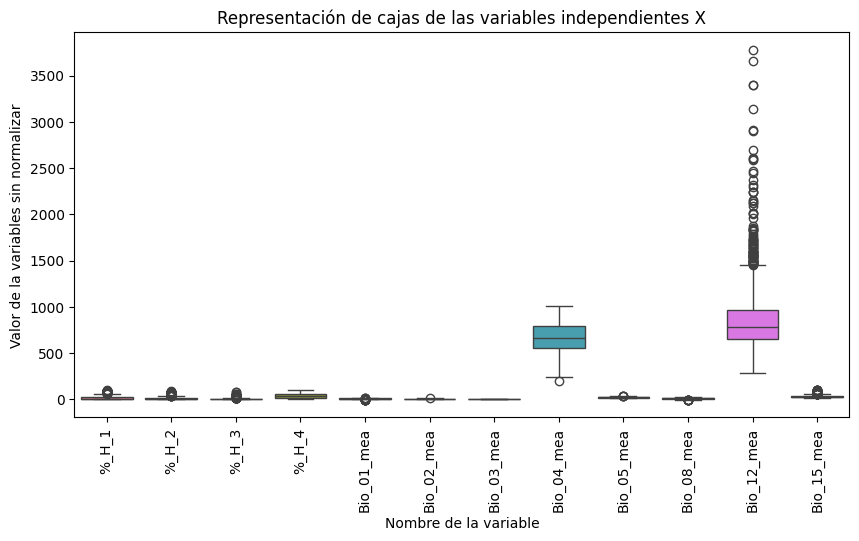

In [26]:
### Distribucion de las variables independientes
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=X)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variables sin normalizar')
_ = plt.xlabel('Nombre de la variable')

Mediante el diagrama de cajas anterior, se puede observar la distribución de cada variable independiente, observandose como entre ellas presentan una gran dispersión y asimetria. Por esta razón a continuación se realizará una normalización de los datos.

In [27]:
X_normalizado = (X-X.mean())/X.std()
X_normalizado.head()

,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,0.605929,-0.622443,-0.575450,-0.026060,2.048417,0.645738,1.453916,-1.269190,1.425366,0.416348,-1.324326,1.628368
12,2.426909,-0.622443,-0.575450,-1.037290,1.989572,-1.211617,0.109305,-2.027638,0.663128,0.629296,-0.473606,2.842842
18,2.617827,-0.617148,-0.574194,-1.282156,2.076742,-2.181876,-2.241921,-1.231687,0.783714,0.586402,-0.270957,4.191671
26,0.953286,-0.422679,-0.557964,-0.711754,1.679765,-1.000940,-0.495845,-1.267122,0.754519,0.088695,-1.005052,2.169311
37,0.355384,-0.312653,-0.232960,-0.626116,1.540021,-0.281651,-0.061908,-0.557684,1.156162,-0.193190,0.117076,3.423703


C:\Users\molic\AppData\Local\Temp\ipykernel_2012\1290797644.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


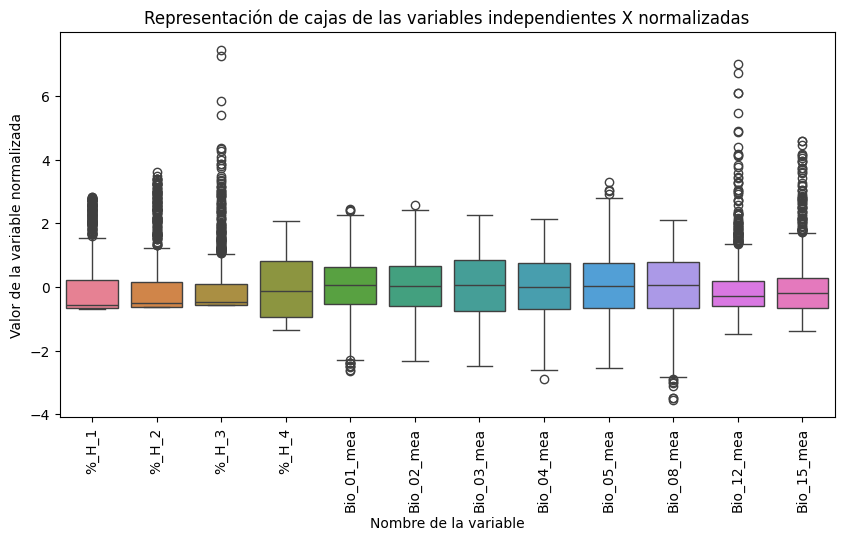

In [28]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X normalizadas')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

### Relación variable vs target:

In [29]:
def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='green')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='red')
    plt.title(title, fontsize=24)
    plt.legend(loc='best', fontsize=14) 
    
def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat,)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

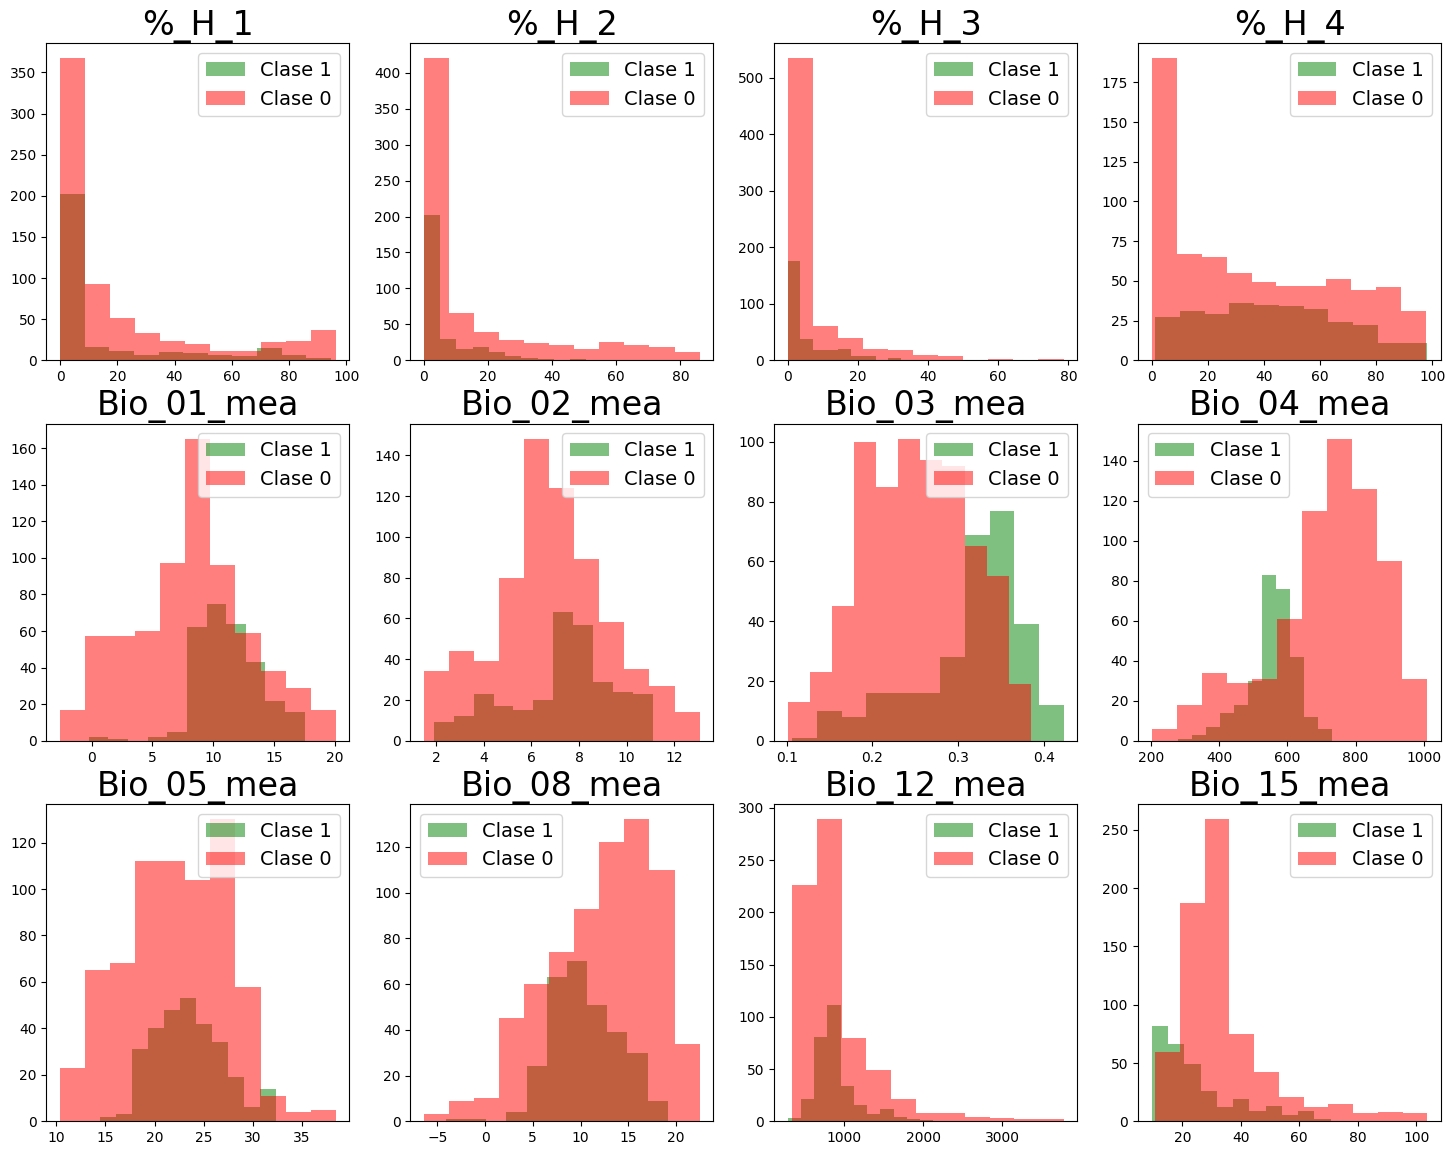

In [30]:
hist_pos_neg_feat(X,Y)

## Dividir los datos en conjuntos de entrenamiento y prueba

Una vez se han normalizado los datos, se ha procedido a dividir los datos en conjuntos de train y test para el entrenamiento del modelo de Random Forest. Para ello, se ha utilizad la función ‘train_test_split’ de la biblioteca ‘Scikit-learn’ (Pedregosa et al. 2011) en Python. El conjunto de datos se separó en un 80% para entrenamiento y un 20% para prueba. 

Para asegurar la reproducibilidad de los resultados, se ha utilizado un valor fijo de semilla (random_state=0). 

In [31]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_normalizado, Y, test_size=0.2, random_state=0)

## Entrenamiento del modelo

Para el entrenamiento del modelo, se utilizó el algoritmo Random Forest mediante la clase ‘RandomForestClassifier’ de ‘Scikit-learn’. 

Además, se ha realizado una búsqueda exhaustiva de los mejores hiperparámetros mediante el método ‘GridSearchCV’, con validación cruzada de 3 particiones (cv=3) para garantizar una selección óptima. Es decir, el conjunto de datos se divide en 3 subconjuntos y en cada iteración, dos de los subconjuntos se usan para entrenar el modelo, y el tercero se usa para validarlo, repitiendo este proceso tres veces, cambiando el subconjunto de validación en cada iteración. 

Los hiperparámetros evaluados incluyeron el número de árboles en el bosque (‘n_estimators’), la profundidad máxima de cada árbol (‘max_depth’) y el número máximo de características a considerar para dividir cada nodo (‘max_features’).

In [32]:
# Definición del modelo
random_forest = RandomForestClassifier()

# Busqueda de los mejores hiperparametros
params = {"n_estimators" : [10, 50, 100, 200],
         "max_depth" : [5, 7, 9],
         "max_features": [10, "sqrt"]}

# Se realiza una búsqueda de hiperparámetros con validación cruzada (GridSearchCV)
modelo_rf_gs  = GridSearchCV(random_forest, params, cv=3, n_jobs=-1)
modelo_rf_gs .fit(X_train, Y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 'sqrt'],
                         'n_estimators': [10, 50, 100, 200]})

In [33]:
## Mostrar los mejores parámetros y la precisión en los datos de entrenamiento y prueba
print(u'Mejores parámetros del modelo: {}'.format(modelo_rf_gs .best_params_))
print('- Accuracy de los datos de train: {} \n- Accuracy de los datos de test: {}'\
                        .format(modelo_rf_gs .score(X_train, Y_train), 
                        round(modelo_rf_gs .score(X_test, Y_test),2)))

Mejores parámetros del modelo: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 50}
- Accuracy de los datos de train: 0.9911054637865311 
- Accuracy de los datos de test: 0.94


Según la busqueda anterior realizada con validacion cruzada (GridSearchCV), los mejores hiperparámetros encontrados para el modelo de Random Forest son los siguientes:

- **max_depth**: 7. Indica la profundidad máxima de los árboles. Limitar la profundidad puede ayudar a evitar el sobreajuste.
- **max_features**: 'sqrt'. Representa la cantidad de características a considerar para dividir un nodo. 'sqrt' significa que se considerará la raíz cuadrada del número total de características.
- **n_estimators**: 50. Indica el número de árboles en el bosque.

En cuanto a la precisión de los datos de entrenamiento y testeo:

- **Accuracy de los datos de train (0.99)**: Muestra que el modelo tiene una precisión del 99% en los datos de entrenamiento.

- **Accuracy de los datos de test (0.94)**: Muestra que el modelo también tiene una precisión del 94% en los datos de prueba.

In [34]:
# Crear un DataFrame con los resultados
df_search_rf = pd.DataFrame.from_dict(modelo_rf_gs .cv_results_)
df_search_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       24 non-null     float64
 1   std_fit_time        24 non-null     float64
 2   mean_score_time     24 non-null     float64
 3   std_score_time      24 non-null     float64
 4   param_max_depth     24 non-null     int64  
 5   param_max_features  24 non-null     object 
 6   param_n_estimators  24 non-null     int64  
 7   params              24 non-null     object 
 8   split0_test_score   24 non-null     float64
 9   split1_test_score   24 non-null     float64
 10  split2_test_score   24 non-null     float64
 11  mean_test_score     24 non-null     float64
 12  std_test_score      24 non-null     float64
 13  rank_test_score     24 non-null     int32  
dtypes: float64(9), int32(1), int64(2), object(2)
memory usage: 2.7+ KB


El DataFrame resultante, *'df_search_rf'*, proporciona información detallada sobre la búsqueda de hiperparámetros y la validación cruzada. Las columnas que contiene son: 

- mean_fit_time: Tiempo medio para ajustar el modelo.
- std_fit_time: Desviación estándar del tiempo de ajuste.
- mean_score_time: Tiempo medio para calcular el puntaje.
- std_score_time: Desviación estándar del tiempo de puntuación.
- param_<param_name>: Valores de los parámetros utilizados en cada combinación.
- mean_test_score: Precisión media en los datos de prueba para cada combinación.
- std_test_score: Desviación estándar de la precisión en los datos de prueba.
- rank_test_score: Clasificación de la combinación de parámetros basada en la precisión.

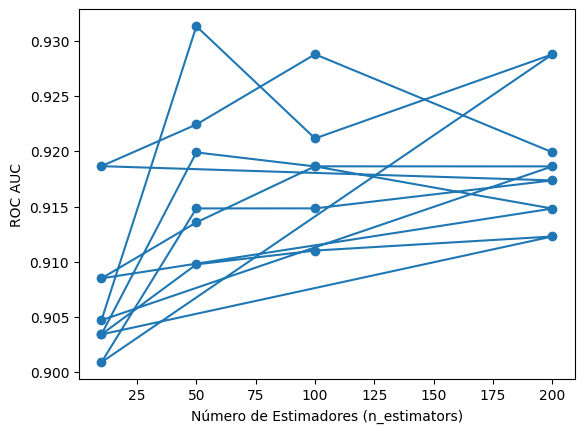

In [35]:
# Visualizar los resultados
plt.xlabel('Número de Estimadores (n_estimators)')
plt.ylabel('ROC AUC')
plt.plot(df_search_rf['param_n_estimators'], df_search_rf['mean_test_score'], marker='o')
plt.show()

El gráfico anterior permite visualizar cómo cambia el rendimiento del modelo (medido por el ROC AUC) a medida que se ajusta el número de estimadores (n_estimators).

## Evaluación del modelo

### Valor del AUC (Área bajo la Curva ROC)

Además de la evaluación con la métrica de precisión, se ha utilizado el área bajo la curva ROC (AUC, por sus siglas en inglés) para validar el rendimiento de los modelos entrenados para cada especie. 

La AUC es una métrica que mide la capacidad del modelo para discriminar entre clases, calculando el área bajo la curva ROC, la cual grafica la tasa de verdaderos positivos frente a la tasa de falsos positivos a diferentes umbrales de clasificación (Fawcett, 2006). Se ha elegido la AUC como métrica complementaria debido a su capacidad para proporcionar una evaluación más completa del desempeño del modelo. Una AUC cercana a 1 indica un buen rendimiento del modelo en términos de su capacidad para distinguir correctamente entre las clases (Cancellario et al. 2022).

In [36]:
# Predicción de las probabilidades en el conjunto de Test y calculo la métrica ROC AUC con el modelo_gs
y_test_pred_prob_RF = modelo_rf_gs.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob_RF[:,1])

np.float64(0.9856486796785305)

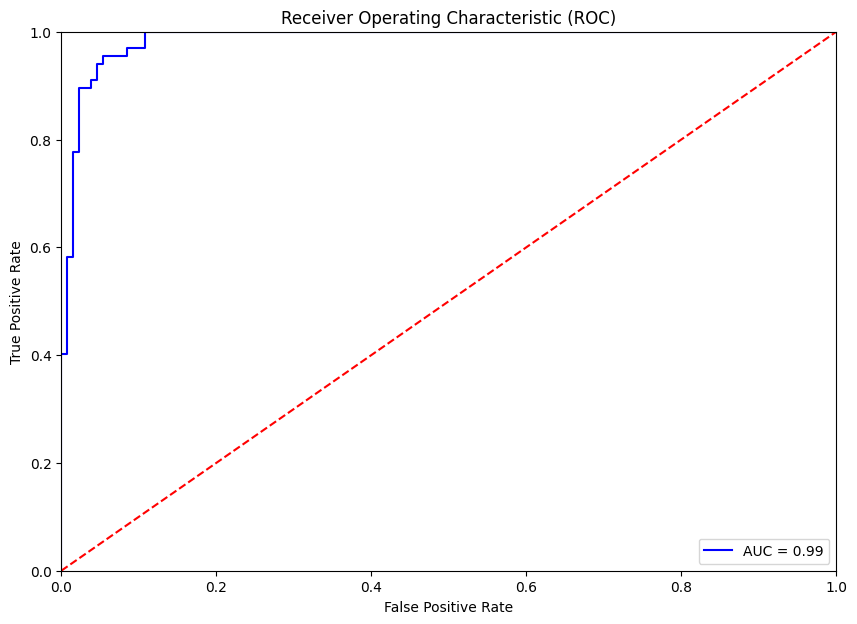

In [37]:
# Representa la curva ROC de las predicciones en Test
preds = y_test_pred_prob_RF[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
# Representa los histogramas de probabilidad de las predicciones en Test
y_test_pred_prob_RF = modelo_rf_gs.predict_proba(X_test)
y_test_pred_prob_pos_RF = y_test_pred_prob_RF[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg_RF = y_test_pred_prob_RF[np.where(Y_test == 0)[0]]

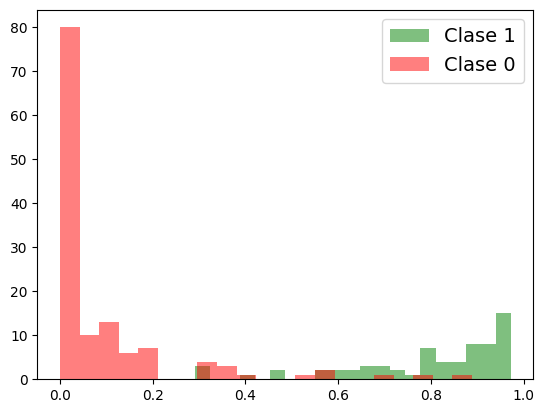

In [39]:
represento_doble_hist(y_test_pred_prob_pos_RF[:, 1], y_test_pred_prob_neg_RF[:, 1], n_bins=21, density =0)

### Matriz de confusión

También se ha utilizado la matriz de confusión para evaluar la eficiencia de los modelos. La matriz de confusión es una herramienta muy utilizada para obtener información acerca del desempeño de un algoritmo. La matriz de confusión también es conocida como matriz de error o tabla de contingencia, debido a su funcionamiento como una herramienta estadística para el análisis de observaciones emparejadas (Inca Balseca et al., 2022).

In [40]:
# Umbralización de las predicciones
umbral = 0.6
y_umbralizadas_RF = 1*(y_test_pred_prob_RF[:, 1] > umbral)

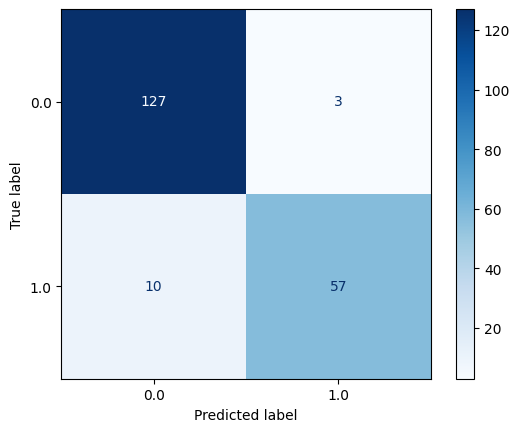

In [41]:
# Matriz de confusión
cm = confusion_matrix(Y_test, y_umbralizadas_RF)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_rf_gs.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [42]:
# Metricas de la matriz de confusión
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas_RF))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas_RF),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas_RF),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas_RF),2)))  

Matriz de confusión
 [[127   3]
 [ 10  57]]

Accuracy	0.93
Sensitividad	0.85
Precisión	0.95


Los resultados obtenidos con la matriz de confusión son los siguientes:

- **Verdaderos Positivos (TP)**: Hay 127 cuadriculas correctamente clasificadas como positivas.
- **Falsos Positivos (FP)**: Hay 3 cuadrículas clasificadas incorrectamente como positivas (falsos negativos).
- **Verdaderos Negativos (TN)**: En total hay 57 cuadriculas correctamente clasificadas como negativas.
- **Falsos Negativos (FN)**: Hay 10 cuadrículas clasificadas incorrectamente como negativas (falsos positivos).

Las métricas calculadas a partir de la matriz de confusión son las siguientes:

- **Precisión (Accuracy)**: 0.93, lo que significa que el modelo clasificó correctamente el 94% de las instancias en el conjunto de datos.
- **Sensibilidad (Recall)**: 0.85, que indica la capacidad del modelo para identificar correctamente las instancias positivas.
- **Precisión (Precision)**: 0.95, lo que indica que el 97% de las instancias clasificadas como positivas realmente lo son. 

In [43]:
# Guardar el modelo entrenado
import joblib
joblib.dump(modelo_rf_gs, 'Data/Results/Model/modelo_rf_gs_sp6.pkl')

['Data/Results/Model/modelo_rf_gs_sp6.pkl']

# Predecciones para el escenario actual (año 2010)

Se utilizara el dataset 'all_data' que contiene toda las cuadricula de la malla de 50x50Km para el area de estudio (Europa). De este dataset, se eliminará la variabe 'sp1_data' ya que es la variable que se quiere predecir y son los datos empleados para el desarrollo del modelo.

In [44]:
all_data.columns

Index(['ET_ID', 'COUNTRY', 'x', 'y', 'sp6_data', 'geometry', '%_H_1', '%_H_2',
       '%_H_3', '%_H_4', 'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea',
       'Bio_04_mea', 'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea'],
      dtype='object')

In [45]:
columns_select = ('ET_ID', 'x', 'y', 'geometry', '%_H_1', '%_H_2', '%_H_3', '%_H_4',
       'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea',
       'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea')

# Selecciona solo las columnas especificadas en la lista columns_select
all_data = all_data[list(columns_select)]
all_data.columns

Index(['ET_ID', 'x', 'y', 'geometry', '%_H_1', '%_H_2', '%_H_3', '%_H_4',
       'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea',
       'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea'],
      dtype='object')

A continuacion se seleccionan solo las features

In [46]:
features = ['%_H_1', '%_H_2', '%_H_3', '%_H_4', 'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea']

In [47]:
# Extraer las características del GeoDataFrame
X_new = all_data[features]

In [48]:
# Normalizar los datos al igual que en el desarrollo del modelo
X_new_normalizado = (X_new-X_new.mean())/X_new.std()
X_new_normalizado.head()

,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,0.683620,-0.597950,-0.549197,-0.100815,2.003174,0.509557,1.491430,-1.376166,1.284339,0.309755,-1.292989,1.429876
1,2.721205,-0.597950,-0.549197,-1.206258,2.208510,-2.341683,-2.468442,-1.538415,0.706447,0.746721,-0.870389,3.042138
2,2.472115,-0.597950,-0.549197,-1.046678,2.049886,-1.429794,-0.490809,-1.912745,0.605468,0.518792,-1.204234,1.766896
3,1.079488,-0.495647,-0.545571,-0.825136,1.884364,-1.192061,-0.702698,-1.107006,0.883207,0.180130,-0.119548,3.636799
4,1.224244,-0.590172,-0.549197,-0.689321,1.862924,-1.362513,-0.968327,-1.093198,0.764217,0.146383,-0.295904,3.456827


In [49]:
# Cargar el modelo entrenado
modelo_rf_gs = joblib.load('Data/Results/Model/modelo_rf_gs_sp6.pkl')

In [50]:
# Obtener las predicciones de probabilidad
y_pred_proba = modelo_rf_gs.predict_proba(X_new_normalizado)[:, 1]  # Probabilidad de la clase positiva

In [51]:
# Añadir las probabilidades de presencia al GeoDataFrame
all_data['probabilidad_presencia'] = y_pred_proba

c:\Users\molic\anaconda3\envs\Bufonidae\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [52]:
# Verificar que las probabilidades se han unido correctamente
print(all_data[['ET_ID', 'probabilidad_presencia']].head())


   ET_ID  probabilidad_presencia
0    249                0.504151
1    280                0.064616
2    363                0.297966
3    412                0.178001
4    413                0.222412


## Visualización de la probabilidad de presencia

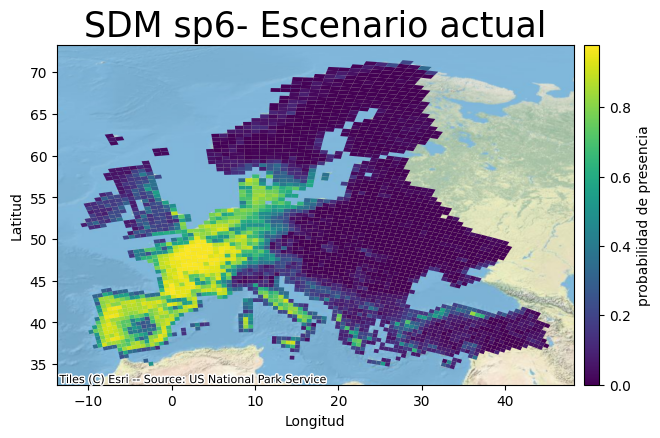

In [53]:
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('SDM sp6- Escenario actual', fontsize=25)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plotear el GeoDataFrame con un gradiente de color según la riqueza de especies
all_data.plot(column='probabilidad_presencia', ax=ax, legend=True, cax=cax,
                    legend_kwds={'label': "probabilidad de presencia", 'orientation': "vertical"},
                    cmap='viridis')

ctx.add_basemap(ax, crs=all_data.crs.to_string(), source=ctx.providers.Esri.WorldPhysical)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

plt.show()

In [54]:
# Guardar el GeoDataFrame en un archivo Shapefile
all_data.to_file('Data/Results/SDM_2010_sp6.shp')
# Guardar el DataFrame en un archivo CSV
all_data.to_csv('Data/Results/SDM_2010_sp6.csv', index=False)

C:\Users\molic\AppData\Local\Temp\ipykernel_2012\257271897.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_data.to_file('Data/Results/SDM_2010_sp6.shp')
c:\Users\molic\anaconda3\envs\Bufonidae\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'probabilidad_presencia' to 'probabilid'
  ogr_write(


## Umbralizar las predicciones

A partir de una probabilidad del 60% se considerá presencia presencia de la especie.

In [55]:
all_data.head(2)

,ET_ID,x,y,geometry,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea,probabilidad_presencia
0,249,-2,35,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839...",35.2700,0.0,0.0,37.6820,18.2550,8.4956,0.3680,462.7157,29.4562,13.8649,345.2101,57.2502,0.504151
1,280,14,36,"POLYGON ((14.68659 35.53849, 14.14122 35.56449...",90.1848,0.0,0.0,5.5578,19.1658,1.5286,0.1101,436.0108,26.6743,16.1710,510.0062,83.7500,0.064616


In [56]:
# Umbralización de la columna de probabilidad_presencia al 60% (0.60)
all_data['umbral'] = all_data['probabilidad_presencia'].apply(lambda x: 1 if x >= 0.60 else 0)
all_data['umbral'].value_counts(dropna=False)

umbral
0    2534
1     572
Name: count, dtype: int64

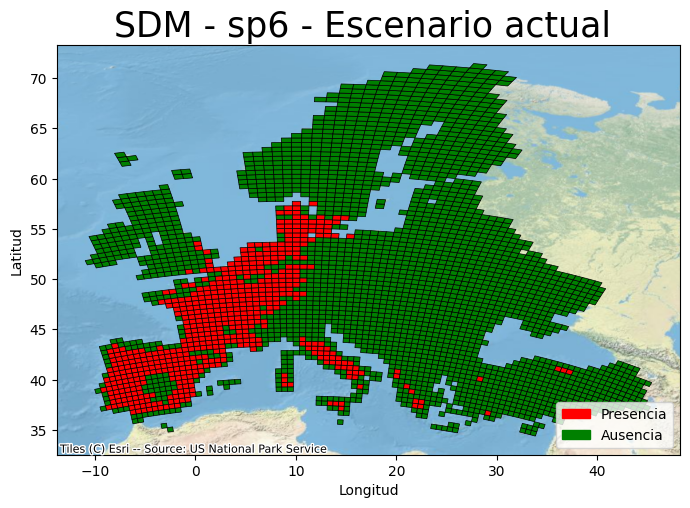

In [57]:
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('SDM - sp6 - Escenario actual ', fontsize=25)

# Filtrar las cuadrículas que tienen presencia de la especie actual
cuadriculas_con_especie = all_data[all_data['umbral'] > 0]
# Filtrar las cuadrículas que no tienen presencia de la especie actual
cuadriculas_sin_especie = all_data[all_data['umbral'] == 0]
# Trazar las cuadrículas sin presencia de la especie actual en azul
cuadriculas_sin_especie.plot(ax=ax, color='green', edgecolor='black', linewidth=0.5)
# Trazar las cuadrículas con presencia de la especie actual en rojo
cuadriculas_con_especie.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5)

ctx.add_basemap(ax, crs=all_data.crs.to_string(), source=ctx.providers.Esri.WorldPhysical)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

presence_patch = mpatches.Patch(color='red', label='Presencia')
absence_patch = mpatches.Patch(color='green', label='Ausencia')

ax.legend(handles=[presence_patch, absence_patch], loc='lower right')
plt.tight_layout()

plt.show()

# Predecciones para el escenario futuro  (año 20100)

## Escenario RCP2-6 

El escenario RCP2-6 es el escenario de bajas emisiones

In [58]:
#Cargar el grid
variables_RCP2_6 = gpd.read_file(r'Data/Variables/RCP2_6/Grid_Variables_RCP2_6.shp')
variables_RCP2_6.head(2)

,ET_ID,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea,geometry
0,249,35.2700,0.0187,0.0719,11.3849,19.6038,8.9262,0.3675,469.2221,31.0437,15.1530,312.1147,56.5510,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839..."
1,280,90.1817,0.0000,0.0000,0.0341,20.2600,1.7725,0.1174,452.8224,28.2771,16.9885,487.7090,86.4136,"POLYGON ((14.68659 35.53849, 14.14122 35.56449..."


In [59]:
print('Valores faltantes por columna:')
variables_RCP2_6.isnull().sum()

Valores faltantes por columna:


ET_ID         0
%_H_1         0
%_H_2         0
%_H_3         0
%_H_4         0
Bio_01_mea    0
Bio_02_mea    0
Bio_03_mea    0
Bio_04_mea    0
Bio_05_mea    0
Bio_08_mea    0
Bio_12_mea    0
Bio_15_mea    0
geometry      0
dtype: int64

In [60]:
features = ['%_H_1', '%_H_2', '%_H_3', '%_H_4', 
            'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea']

In [61]:
# Extraer las características del GeoDataFrame
X_new = variables_RCP2_6[features]

In [62]:
# Normalizar los datos al igual que en el desarrollo del modelo
X_new_normalizado = (X_new-X_new.mean())/X_new.std()
X_new_normalizado.head()

,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,0.696174,-0.521125,-0.500859,-0.246716,1.974871,0.328783,1.302652,-1.416724,1.075970,0.309387,-1.399325,1.243984
1,2.747220,-0.522531,-0.510986,-1.004349,2.122572,-2.235742,-2.537284,-1.513974,0.558907,0.652514,-0.963232,3.041898
2,2.496587,-0.519019,-0.509239,-0.856945,1.966003,-1.459649,-0.631902,-1.991968,0.392814,0.343353,-1.323746,1.591976
3,1.094448,-0.388588,-0.503099,0.520703,1.853955,-1.248534,-0.934368,-1.055132,0.748886,0.046998,-0.044746,3.565199
4,1.240281,-0.483853,-0.510986,0.541367,1.837794,-1.390353,-1.175420,-1.017353,0.647701,-0.043088,-0.236178,3.406056


In [63]:
# Cargar el modelo entrenado
modelo_rf_gs = joblib.load('Data/Results/Model/modelo_rf_gs_sp6.pkl')

In [64]:
# Obtener las predicciones de probabilidad
y_pred_proba = modelo_rf_gs.predict_proba(X_new_normalizado)[:, 1]  # Probabilidad de la clase positiva

# Añadir las probabilidades de presencia al GeoDataFrame
variables_RCP2_6['probabilidad_presencia'] = y_pred_proba

# Verificar que las probabilidades se han unido correctamente
print(variables_RCP2_6[['ET_ID', 'probabilidad_presencia']].head())


   ET_ID  probabilidad_presencia
0    249                0.528102
1    280                0.089377
2    363                0.294993
3    412                0.153250
4    413                0.192595


## Visualización de la probabilidad de presencia

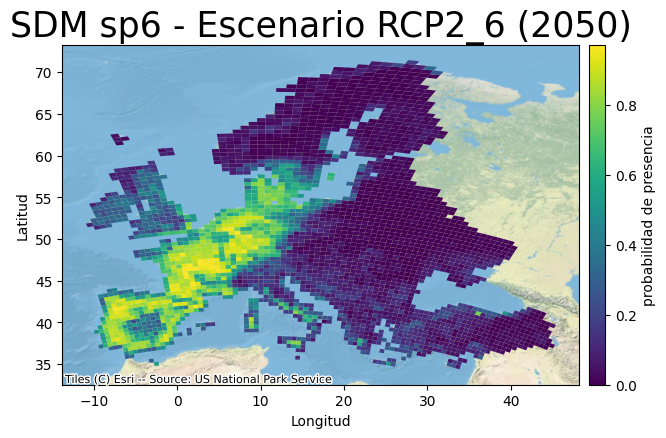

In [65]:
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(7, 7))

# Añadir un título
ax.set_title('SDM sp6 - Escenario RCP2_6 (2050)', fontsize=25)

# Crear un colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plotear el GeoDataFrame con un gradiente de color según la riqueza de especies
variables_RCP2_6.plot(column='probabilidad_presencia', ax=ax, legend=True, cax=cax,
                    legend_kwds={'label': "probabilidad de presencia", 'orientation': "vertical"},
                    cmap='viridis')

# Añadir el mapa base
ctx.add_basemap(ax, crs=variables_RCP2_6.crs.to_string(), source=ctx.providers.Esri.WorldPhysical)

# Añadir etiquetas y leyenda
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el mapa
plt.show()

In [66]:
# Guardar el GeoDataFrame en un archivo Shapefile
variables_RCP2_6.to_file('Data/Results/SDM_2050_RCP2_6_sp6.shp')
# Guardar el DataFrame en un archivo CSV
variables_RCP2_6.to_csv('Data/Results/SDM_2050_RCP2_6_sp6..csv', index=False)

C:\Users\molic\AppData\Local\Temp\ipykernel_2012\3205650589.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  variables_RCP2_6.to_file('Data/Results/SDM_2050_RCP2_6_sp6.shp')
c:\Users\molic\anaconda3\envs\Bufonidae\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'probabilidad_presencia' to 'probabilid'
  ogr_write(


## Ubralizar las predicciones

A partir de una probabilidad del 60% se considerá presencia presencia de la especie.

In [67]:
variables_RCP2_6.head(2)

,ET_ID,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea,geometry,probabilidad_presencia
0,249,35.2700,0.0187,0.0719,11.3849,19.6038,8.9262,0.3675,469.2221,31.0437,15.1530,312.1147,56.5510,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839...",0.528102
1,280,90.1817,0.0000,0.0000,0.0341,20.2600,1.7725,0.1174,452.8224,28.2771,16.9885,487.7090,86.4136,"POLYGON ((14.68659 35.53849, 14.14122 35.56449...",0.089377


In [68]:
# Umbralización de la columna de probabilidad_presencia al 60% (0.60)
variables_RCP2_6['umbral'] = variables_RCP2_6['probabilidad_presencia'].apply(lambda x: 1 if x >= 0.60 else 0)
variables_RCP2_6['umbral'].value_counts(dropna=False)

umbral
0    2561
1     545
Name: count, dtype: int64

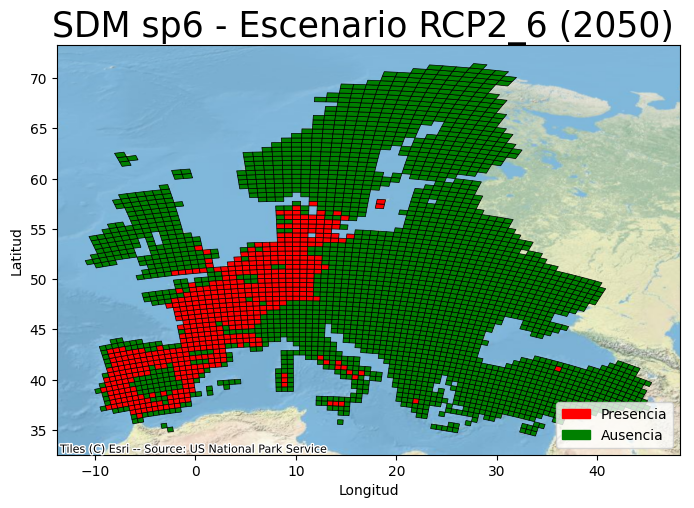

In [69]:
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('SDM sp6 - Escenario RCP2_6 (2050) ', fontsize=25)

# Filtrar las cuadrículas que tienen presencia de la especie actual
cuadriculas_con_especie = variables_RCP2_6[variables_RCP2_6['umbral'] > 0]
# Filtrar las cuadrículas que no tienen presencia de la especie actual
cuadriculas_sin_especie = variables_RCP2_6[variables_RCP2_6['umbral'] == 0]
# Trazar las cuadrículas sin presencia de la especie actual en azul
cuadriculas_sin_especie.plot(ax=ax, color='green', edgecolor='black', linewidth=0.5)
# Trazar las cuadrículas con presencia de la especie actual en rojo
cuadriculas_con_especie.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5)

ctx.add_basemap(ax, crs=variables_RCP2_6.crs.to_string(), source=ctx.providers.Esri.WorldPhysical)

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

presence_patch = mpatches.Patch(color='red', label='Presencia')
absence_patch = mpatches.Patch(color='green', label='Ausencia')

ax.legend(handles=[presence_patch, absence_patch], loc='lower right')
plt.tight_layout()

plt.show()

## Escenario RCP8-5

El escenario RCP8-5 es el escenario de bajas emisiones

In [70]:
#Cargar el grid
variables_RCP8_5 = gpd.read_file(r'Data/Variables/RCP8_5/Grid_Variables_RCP8_5.shp')
variables_RCP8_5.head(2)

,ET_ID,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea,geometry
0,249,35.2700,0.0281,0.1187,28.1217,21.8974,9.2076,0.3634,491.7888,33.9302,16.6901,285.9617,54.3979,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839..."
1,280,90.1817,0.0000,0.0000,0.0403,22.5214,1.7155,0.1106,475.0490,30.9473,19.1874,436.3408,85.7137,"POLYGON ((14.68659 35.53849, 14.14122 35.56449..."


In [71]:
print('Valores faltantes por columna:')
variables_RCP8_5.isnull().sum()

Valores faltantes por columna:


ET_ID         0
%_H_1         0
%_H_2         0
%_H_3         0
%_H_4         0
Bio_01_mea    0
Bio_02_mea    0
Bio_03_mea    0
Bio_04_mea    0
Bio_05_mea    0
Bio_08_mea    0
Bio_12_mea    0
Bio_15_mea    0
geometry      0
dtype: int64

In [72]:
features = ['%_H_1', '%_H_2', '%_H_3', '%_H_4', 
            'Bio_01_mea', 'Bio_02_mea', 'Bio_03_mea', 'Bio_04_mea', 'Bio_05_mea', 'Bio_08_mea', 'Bio_12_mea', 'Bio_15_mea']

In [73]:
# Extraer las características del GeoDataFrame
X_new = variables_RCP8_5[features]

# Normalizar los datos al igual que en el desarrollo del modelo
X_new_normalizado = (X_new-X_new.mean())/X_new.std()
X_new_normalizado.head()

,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea
0,0.697856,-0.500261,-0.476889,0.700811,1.929240,0.445314,1.390587,-1.390892,0.909539,0.369504,-1.325985,1.126173
1,2.750432,-0.502381,-0.494877,-1.020764,2.071387,-2.066943,-2.534527,-1.494565,0.399705,0.803553,-0.969577,2.913295
2,2.499611,-0.496278,-0.492043,-0.484006,1.819098,-1.224014,-0.480363,-1.984609,0.241110,0.430024,-1.280842,1.459317
3,1.096076,-0.384222,-0.486391,0.432858,1.775702,-1.115672,-0.794000,-1.059721,0.535534,0.183982,-0.328895,3.548208
4,1.242368,-0.468289,-0.494877,0.452464,1.769894,-1.214692,-0.967897,-1.023393,0.436726,0.097079,-0.470744,3.360746


In [74]:
# Cargar el modelo entrenado
modelo_rf_gs = joblib.load('Data/Results/Model/modelo_rf_gs_sp6.pkl')

In [75]:
# Obtener las predicciones de probabilidad
y_pred_proba = modelo_rf_gs.predict_proba(X_new_normalizado)[:, 1]  # Probabilidad de la clase positiva

# Añadir las probabilidades de presencia al GeoDataFrame
variables_RCP8_5['probabilidad_presencia'] = y_pred_proba
print(variables_RCP8_5[['ET_ID', 'probabilidad_presencia']].head())


   ET_ID  probabilidad_presencia
0    249                0.549791
1    280                0.089377
2    363                0.319651
3    412                0.230676
4    413                0.250086


## Visualización de la probabilidad de presencia

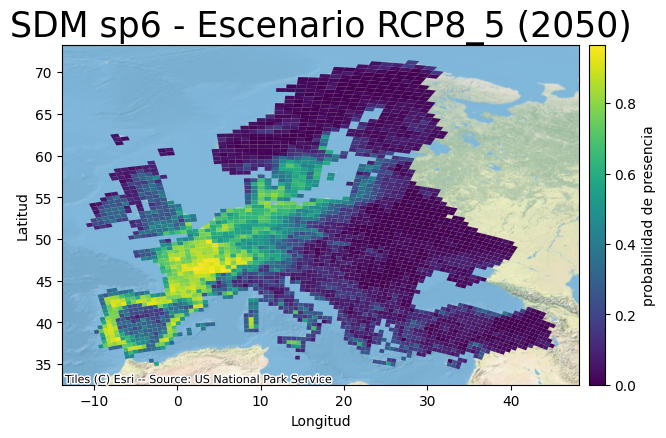

In [76]:
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('SDM sp6 - Escenario RCP8_5 (2050)', fontsize=25)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plotear el GeoDataFrame con un gradiente de color según la riqueza de especies
variables_RCP8_5.plot(column='probabilidad_presencia', ax=ax, legend=True, cax=cax,
                    legend_kwds={'label': "probabilidad de presencia", 'orientation': "vertical"},
                    cmap='viridis')


ctx.add_basemap(ax, crs=variables_RCP8_5.crs.to_string(), source=ctx.providers.Esri.WorldPhysical)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

plt.show()

In [77]:
# Guardar el GeoDataFrame en un archivo Shapefile
variables_RCP8_5.to_file('Data/Results/SDM_2050_RCP8_5_sp6.shp')
# Guardar el DataFrame en un archivo CSV
variables_RCP8_5.to_csv('Data/Results/SDM_2050_RCP8_5_sp6..csv', index=False)

C:\Users\molic\AppData\Local\Temp\ipykernel_2012\813639738.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  variables_RCP8_5.to_file('Data/Results/SDM_2050_RCP8_5_sp6.shp')
c:\Users\molic\anaconda3\envs\Bufonidae\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'probabilidad_presencia' to 'probabilid'
  ogr_write(


## Ubralizar las predicciones

A partir de una probabilidad del 60% se considerá presencia presencia de la especie.

In [78]:
variables_RCP8_5.head(2)

,ET_ID,%_H_1,%_H_2,%_H_3,%_H_4,Bio_01_mea,Bio_02_mea,Bio_03_mea,Bio_04_mea,Bio_05_mea,Bio_08_mea,Bio_12_mea,Bio_15_mea,geometry,probabilidad_presencia
0,249,35.2700,0.0281,0.1187,28.1217,21.8974,9.2076,0.3634,491.7888,33.9302,16.6901,285.9617,54.3979,"POLYGON ((-2.18083 34.85145, -2.71695 34.77839...",0.549791
1,280,90.1817,0.0000,0.0000,0.0403,22.5214,1.7155,0.1106,475.0490,30.9473,19.1874,436.3408,85.7137,"POLYGON ((14.68659 35.53849, 14.14122 35.56449...",0.089377


In [79]:
# Umbralización de la columna de probabilidad_presencia al 60% (0.60)
variables_RCP8_5['umbral'] = variables_RCP8_5['probabilidad_presencia'].apply(lambda x: 1 if x >= 0.60 else 0)
variables_RCP8_5['umbral'].value_counts(dropna=False)

umbral
0    2698
1     408
Name: count, dtype: int64

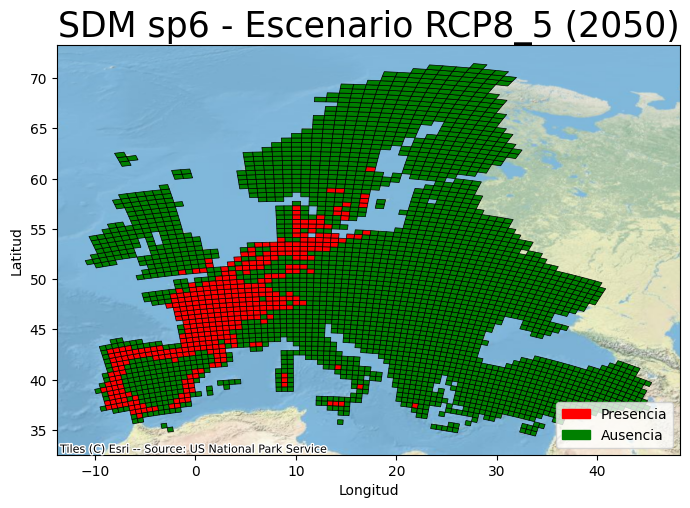

In [80]:
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('SDM sp6 - Escenario RCP8_5 (2050)', fontsize=25)

# Filtrar las cuadrículas que tienen presencia de la especie actual
cuadriculas_con_especie = variables_RCP8_5[variables_RCP8_5['umbral'] > 0]
# Filtrar las cuadrículas que no tienen presencia de la especie actual
cuadriculas_sin_especie = variables_RCP8_5[variables_RCP8_5['umbral'] == 0]
# Trazar las cuadrículas sin presencia de la especie actual en azul
cuadriculas_sin_especie.plot(ax=ax, color='green', edgecolor='black', linewidth=0.5)
# Trazar las cuadrículas con presencia de la especie actual en rojo
cuadriculas_con_especie.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5)

ctx.add_basemap(ax, crs=variables_RCP8_5.crs.to_string(), source=ctx.providers.Esri.WorldPhysical)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

presence_patch = mpatches.Patch(color='red', label='Presencia')
absence_patch = mpatches.Patch(color='green', label='Ausencia')

ax.legend(handles=[presence_patch, absence_patch], loc='lower right')
plt.tight_layout()

plt.show()